# Mathematical Modelling for Sustainable Development
## Coursework Submission 2025
### Serena Farrelly

Question 1: Healthcare Resource Allocation Modelling

Modelling a queuing system to model arriving patients (walk ins and prearranged appointments) and the allocation of four clinicians. We want to assess the efficiency of the system and identify causes of delays.


### Modelling Assumptions

- a patient with an appointment arrives every 30 minutes

In [4]:
# Python Packages
import simpy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
# Class defintions

class HealthService:
    def __init__(self, env, num_clinicians):
        self.env = env
        self.clinicians = simpy.Resource(env, num_clinicians)

    def processPatient(self, patient):
        yield self.env.timeout()


class Patient:
    def __init__(self, id, type, entry_time):
        self.id = id
        self.type = type
        self.entry_time = entry_time
        self.exit_time = 9999 # arbitrary high number. Gets updated when patient exits
    
    def __str__(self):
        return f"Patient:{self.id}(Type:{self.type}, Entry Time: {self.entry_time}, Exit Time: {self.entry_time})"
    

In [6]:
# Simulation Functions

def Source_appt():
    # regular appointments through out the day
    # they arrive every 30 mins
    # a pretty hellish schedule lol
    return 30


def Source_walkin(mu_walkin):
    # random walkins
    return np.random.exponential(mu_walkin)

def Service_time(mu_service):
    # how long each appmnt takes
    return np.random.exponential(mu_service)

# Simulation function for the queuing system
def HealthCareService(env, clinicians):
    num_patients = 0                                            # Initialise a counter for the patients
    next_patient_time = 0                                       # Intialise time variable to be minimised when the next patient time is determined
    last_patient_type = 1                                       # patient type: 1 = appointment, 2 = walkin
    next_walkin = 0
    while True:                                                 # In this case, while the simulation is running
        
        # Find out which is the next patient: walk in or appointment
        if (next_walkin==0 or last_patient_type == 2):
            # if this value is 0 (initialise) or the last patient was a walkin
            # generate a new talk in time
            next_walkin = Source_walkin(mu_walkin)
        
        # compare which is the next customer: appointment or walkin
        if (next_walkin < Source_appt()):
            last_patient_type = 2
            next_patient_time = next_walkin
        else:
            last_patient_type = 1
            next_patient_time = Source_appt()
        
        # this is essentially a delay simulation until next customer arrival
        yield env.timeout(next_patient_time)
        num_patients += 1                                      # Increment the customer number

        # When the customer arrives, start a new customer process
        env.process(Patient(env, num_patients, clinicians))

# Customer process function to simulate each customer's interaction with the server
def Patient(env, patient, clinicians):
    # Request a server from the pool of available servers
    with clinicians.request() as request:
        t_arrival = env.now  # Capture the arrival time of the customer

        # Track the number of customers currently in the system (both in service and in queue)
        in_systems.append((t_arrival, len(clinicians.queue) + len(clinicians.users)))

        # Log the customer arrival, including the number of customers 
        # print(f'{env.now}: customer {customer} arrives.  Current number of people in the system: {len(servers.queue) + len(servers.users)}')       

        # Yield until the customer gets service (i.e., waits for a server to be available)
        yield request
        ##print(f'{env.now}: customer {customer} is being served')

        # Generate and wait for the service time (time spent being served)
        service_time = Service_time(mu_service)
        yield env.timeout(service_time)

        # Customer departs after service
        t_depart = env.now  # Capture the departure time of the customer

        # Track the number of customers in the system after this customer departs
        in_systems.append((t_depart, len(clinicians.queue) + len(clinicians.users) - 1))

        # Log the customer departure, including the number of customers
        #print(f'{env.now}: customer {customer} departs. Current number of people in the system: {len(servers.queue) + len(servers.users) - 1}')

        # Record the wait time and service time for the customer
        waits.append(t_depart - t_arrival)                      # Calculate the wait time (departure time - arrival time)
        service_t.append(service_time)                          # Record the service time
        service[patient] = service_time, t_depart - t_arrival   # Store service details for the customer




In [7]:
# Initialise lists to store results for wait times, service times, and system state
waits = [] # List to store wait times 
service_t = []  # list to store the service times for each customer
in_systems = [(0,0)] #list to track number of people at the given time
service={}

# Parameters 
mu_walkin = 30                          # mean arrival interspacing for walk in patients (mins)
mu_service = 15                         # mean length of clinician appointment (mins)

# Simulation duration
duration = 1000 #in minutes

# Create the simulation environment and server
env = simpy.Environment()
clinicians = simpy.Resource(env, capacity=4)  # initialise the servers
# Start the simulation
env.process(HealthCareService(env, clinicians))
# Run the simulation for a given time 
env.run(until=duration)


In [8]:
average_service_time = np.mean(service_t)  # Calculate the average customer service time
print(f'average customer service time: {average_service_time:.2f}')

W = np.mean(waits) # Calculate the average wait time across all customers
print(f' average customer wait time: {W:.2f}')

# Loop through the records of system states (time and queue length)
auc, last_t, last_l = 0, 0, 0
for t, l in in_systems:
    auc += (t-last_t)*last_l
    last_t, last_l = t, l
L=auc/last_t # Calculate the average number of customers in the system 
print(f' average number of customers in the system: {L:.2f}')

average customer service time: 11.98
 average customer wait time: 11.98
 average number of customers in the system: 0.39


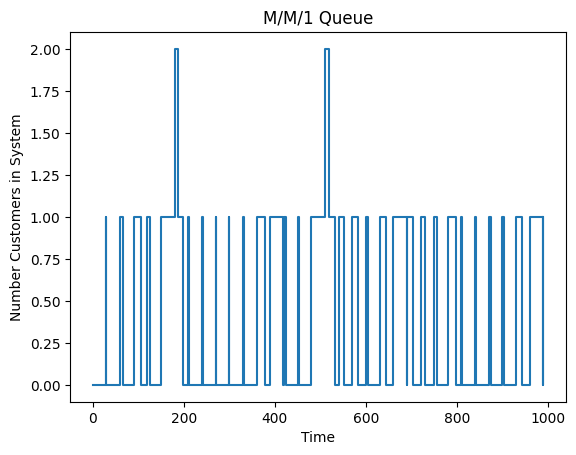

In [9]:
plt.step(*zip(*in_systems[:]), where='post')  # Plot the times of events (arrivals and departures) vs the number of customers at those times. 
plt.title("M/M/1 Queue")                        # Set the title of the plot
plt.xlabel("Time")                              # Label the x-axis as 'Time'
plt.ylabel("Number Customers in System")        # Label the y-axis as 'Number of Customers in System'
plt.show()                                      # Display the plot